# **Team Detox Capstone Project**
## -- Advanced Model Evaluations
## *Clean Notebook* (Amy)  

## Install DeepChem

In [ ]:
!pip install deepchem==2.7.2.dev20230209144634

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.7/709.7 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 47.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1


## Install Torch and check GPU device 

In [ ]:
!pip install torch
import torch
if torch.cuda.is_available():
    print('use GPU')
    device = 'cuda'
else:
    print('use CPU')
    device = 'cpu'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
use GPU


## Import required libraries 

In [ ]:
import deepchem as dc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.utils.parallel import Parallel
from sklearn.utils.parallel import delayed
from deepchem.splits import ScaffoldSplitter
from deepchem.metrics import Metric
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

import random
from copy import deepcopy
import numbers
import time
import timeit
from datetime import datetime
import pytz

##Define function to print timestamp

In [ ]:
date_now = datetime.now().date()
time_SF = datetime.now(pytz.timezone('America/Vancouver'))

def print_sf_time():
  print("Timestamp:", date_now, datetime.now(pytz.timezone('America/Vancouver')).strftime("%H:%M:%S"))

# Advanced Model Evaluations: 
## Multitask Classifier + RDKit Descriptors Model

### Load, featurize and split Tox21 datasets via DeepChem

In [ ]:
#RDKitDescriptors fingerprint computing WITHOUT normalization took 1m ; WITH normalization takes 4x as long 
tox21_tasks2, tox21_datasets2, transformers2 = dc.molnet.load_tox21(featurizer=dc.feat.RDKitDescriptors(is_normalized=False))

train_dataset2, valid_dataset2, test_dataset2 = tox21_datasets2
train_dataset2

[17:19:31] WARNING: not removing hydrogen atom without neighbors
[17:19:31] WARNING: not removing hydrogen atom without neighbors
[17:19:31] WARNING: not removing hydrogen atom without neighbors
[17:21:01] WARNING: not removing hydrogen atom without neighbors


<DiskDataset X.shape: (6264, 208), y.shape: (6264, 12), w.shape: (6264, 12), task_names: ['NR-AR' 'NR-AR-LBD' 'NR-AhR' ... 'SR-HSE' 'SR-MMP' 'SR-p53']>

### Convert NaNs and Infinities to 0 in the datasets

In [ ]:
#Note Deepchem featurizers are supposed to take care of NaNs and infinitites, 
#but this particular RDKitDescriptor featurizer fails to do this, so we have to fix them manually

#Fix NaNs and Infinities
def fill_infs_nans (split_dataset):
  df = pd.DataFrame(split_dataset)
  df = df.replace([np.inf, -np.inf], np.nan)
  df = df.fillna(0)
  return df
print('Is there any NaN in the training dataset? ', np.isnan(train_dataset2.X).any())
print('Is there any infinite value in the training dataset? ', ~np.isfinite(train_dataset2.X).any())

#Need to fix NaN in trai, test and validation sets
train_dataset2_f = dc.data.DiskDataset.from_numpy(fill_infs_nans(train_dataset2.X),train_dataset2.y, train_dataset2.w, 
                                                  ids = train_dataset2.ids, tasks=tox21_tasks2)
test_dataset2_f = dc.data.DiskDataset.from_numpy(fill_infs_nans(test_dataset2.X),test_dataset2.y, test_dataset2.w, 
                                                 ids = test_dataset2.ids,tasks=tox21_tasks2)
valid_dataset2_f = dc.data.DiskDataset.from_numpy(fill_infs_nans(valid_dataset2.X), valid_dataset2.y, valid_dataset2.w, 
                                                  ids = valid_dataset2.ids,tasks=tox21_tasks2)
#No more NAN in training data
print('Is there any NaN in the training dataset? ', np.isnan(train_dataset2_f.X).any())
print('Is there any infinite value in the training dataset? ', ~np.isfinite(train_dataset2_f.X).any())

Is there any NaN in the training dataset?  True
Is there any infinite value in the training dataset?  False
Is there any NaN in the training dataset?  False
Is there any infinite value in the training dataset?  False


### Reload saved model (previously trained on 03/23)

In [ ]:
#Reload saved model instead of retraining
metrics = [dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean, mode="classification"),
           dc.metrics.Metric(dc.metrics.balanced_accuracy_score, np.mean, mode="classification")]
mcrd_reload = dc.models.MultitaskClassifier(
    n_tasks=12, n_features=208, layer_sizes=[1000, 1000], learning_rate = 0.0005, 
    dropouts=0.2, random_state=2, model_dir='./someDirectory/someFolder') 
mcrd_reload.restore()
print_sf_time()
#Scores are the same after restarting runtime with the same reloaded model
mcrd_train_scores = mcrd_reload.evaluate(train_dataset2_f, metrics, transformers2)
mcrd_test_scores = mcrd_reload.evaluate(test_dataset2_f, metrics, transformers2)
print('Train scores: ', mcrd_train_scores)
print('Test scores: ', mcrd_test_scores)

Timestamp: 2023-04-13 10:22:27
Train scores:  {'mean-roc_auc_score': 0.9567101431839092, 'mean-balanced_accuracy_score': 0.8985073352225194}
Test scores:  {'mean-roc_auc_score': 0.7176311177288298, 'mean-balanced_accuracy_score': 0.6479214345498941}


## Confusion Matrix for Multitask Classifier via RDKit Descriptors


### Define function to get data for plotting confusion matrices
Reference: https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix


In [ ]:
def get_confusionmatrix(model, test_dataset):
  #Using reloaded model via checkpoint saved 20230321
  preds = model.predict(test_dataset)
  test_list = list()
  for i in range(len(preds)):
    one_cmpd = preds[i][:, 1].tolist()
    test_list.append(one_cmpd)
  df_test = pd.DataFrame(test_list)
  df_binary = np.where(df_test>0.5, 1, 0)

  y_true = test_dataset.y
  y_pred = df_binary
  cm_all = multilabel_confusion_matrix(y_true, y_pred)
  return cm_all

### Plot Confusion Matrices: figure generation for report

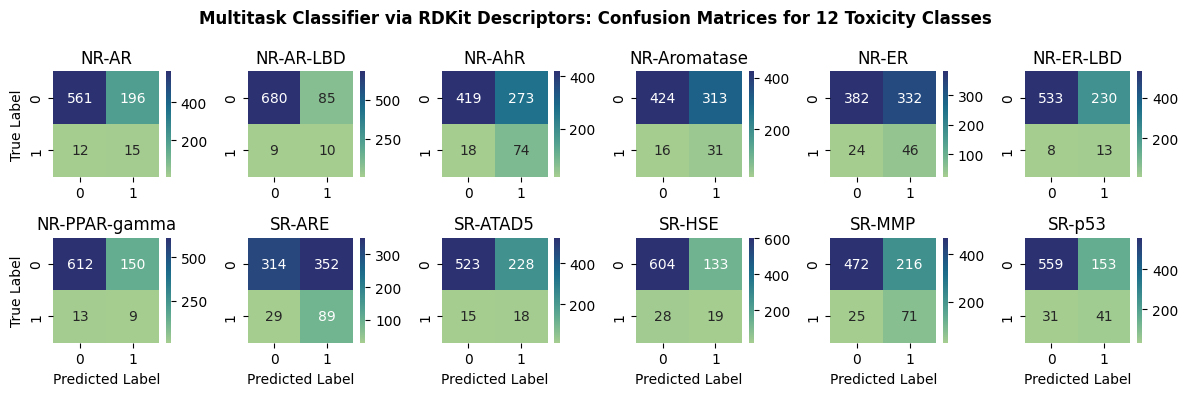

In [ ]:
cm_mcrd = get_confusionmatrix(mcrd_reload, test_dataset2_f)

fig, axes = plt.subplots(2, 6, figsize=(12,4))
fig.suptitle('Multitask Classifier via RDKit Descriptors: Confusion Matrices for 12 Toxicity Classes', weight='bold')
first_six = ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD']
last_six = ['NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']

for i in range(6):
  axes[0][i].set_title(first_six[i])
  sns.heatmap(ax=axes[0][i], data=pd.DataFrame(cm_mcrd[i]), annot=True,cmap='crest', fmt='g')
axes[0][0].set_ylabel('True Label')

for j in range(6):
  axes[1][j].set_title(last_six[j])
  sns.heatmap(ax=axes[1][j], data=pd.DataFrame(cm_mcrd[j+6]), annot=True,cmap='crest', fmt='g')
  axes[1][j].set_xlabel('Predicted Label')
axes[1][0].set_ylabel('True Label')

plt.tight_layout()

## Feature Ablation with cross-validation (CV) for Multitask Classifer with RDKit Descriptors

#### Define functions for CV (adapted from sklearn.model_selection.cross_validate)

In [ ]:
## Adapted from sklearn.model_selection.cross_validate
def dc_cross_validate(
    estimator,
    dataset,
    estimator_params,
    *,   
    metric = [dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean, mode="classification"),dc.metrics.Metric(dc.metrics.balanced_accuracy_score, np.mean, mode="classification")],
    k=5,
    splitter=ScaffoldSplitter(),
    n_jobs=None,
    fit_params=None,
    pre_dispatch="2*n_jobs",
    return_train_score=False):
    
    parallel = Parallel(n_jobs=n_jobs, pre_dispatch=pre_dispatch)
    results = parallel(
        delayed(_custom_fit_and_score)(
        estimator,
        dataset,
        estimator_params,
        train,
        test,
        fit_params,
        metric,
        return_train_score)
        for train, test in splitter.k_fold_split(dataset, k)
        )
    results1 = _aggregate_score_dicts(results, metric[0].name)
    results2 = _aggregate_score_dicts(results, metric[1].name)
    return results1, results2

def _custom_fit_and_score(
    estimator,
    dataset,
    estimator_params,
    train,
    test,
    fit_params,
    metric,
    return_train_score=False):
  estimatorInstance = estimator(**estimator_params)
  start_time = time.time()
  estimatorInstance.fit(train, **fit_params)
  fit_time = time.time() - start_time
  train_score = estimatorInstance.evaluate(train, metric) ##
  test_score = estimatorInstance.evaluate(test, metric) ##
  score_time = time.time() - start_time - fit_time
  total_time = score_time + fit_time
  result = {}
  if return_train_score:
    result["train_score"] = train_score
  result["test_score"] = test_score
  return result

def _aggregate_score_dicts(scores, metric_name):
    return {
        key: np.asarray([score[key][metric_name] for score in scores])
        if isinstance(scores[0][key][metric_name], numbers.Number)
        else [score[key] for score in scores]
        for key in scores[0]}

### Multitask Classifier final model CV results

In [ ]:
estimator_params_mcrd = {'n_tasks':12, 'n_features':208, 'layer_sizes': [1000, 1000], 'dropouts':0.2,'learning_rate': 0.0005,'random_state':2}
fit_params_mcrd ={'nb_epoch':50}
mcrd_merged_traintest = dc.data.NumpyDataset.merge([train_dataset2_f, test_dataset2_f])

mcrd_cv_scores = dc_cross_validate(dc.models.MultitaskClassifier, mcrd_merged_traintest, estimator_params_mcrd, 
                            k=5, fit_params=fit_params_mcrd, return_train_score=True)
mcrd_cv_df = pd.DataFrame(data = {'roc_auc_train': mcrd_cv_scores[0]['train_score'], 
                                 'roc_auc_test': mcrd_cv_scores[0]['test_score'],
                                 'ba_train': mcrd_cv_scores[1]['train_score'], 
                                 'ba_test': mcrd_cv_scores[1]['test_score']})
mcrd_cv_df.describe()

,roc_auc_train,roc_auc_test,ba_train,ba_test
count,5.000000,5.000000,5.000000,5.000000
mean,0.940662,0.748445,0.866703,0.666353
std,0.011180,0.049031,0.020388,0.064131
min,0.926387,0.709871,0.840302,0.587282
25%,0.930824,0.713050,0.850003,0.638961
50%,0.947152,0.730835,0.875249,0.653511
75%,0.948474,0.759797,0.881096,0.693092
max,0.950471,0.828671,0.886866,0.758921


### Define function for feature ablation with CV

In [ ]:
def feature_ablation_cv(features, transformers, train_dataset, test_dataset, k=5):
    auc_scores_list = list()
    ba_scores_list = list()
    features_list = features
    tox21_tasks = ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD','NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']
    metrics = [dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean, mode="classification"),dc.metrics.Metric(dc.metrics.balanced_accuracy_score, np.mean, mode="classification")]

    estimator_params = {'n_tasks':12, 'n_features':208, 'layer_sizes':[1000, 1000],
                    'dropouts':0.2,'learning_rate': 0.0005,'random_state':2}
    fit_params={'nb_epoch':10}
    merged_traintest = dc.data.NumpyDataset.merge([train_dataset, test_dataset])

    cv_scores_all = dc_cross_validate(dc.models.MultitaskClassifier, merged_traintest, estimator_params, 
                            k=k, fit_params=fit_params, return_train_score=True)
    auc_scores_list.append(cv_scores_all[0]['test_score'])
    ba_scores_list.append(cv_scores_all[1]['test_score'])

    X_train_df = pd.DataFrame(train_dataset.X, columns=features)
    X_test_df = pd.DataFrame(test_dataset.X, columns=features)

    for feature in features_list:
        X_train_ab = X_train_df.drop([feature], axis=1)     
        X_test_ab = X_test_df.drop([feature], axis=1)
        
        train_ab = dc.data.DiskDataset.from_numpy(X_train_ab.values,train_dataset.y, train_dataset.w, 
                                                  tasks=tox21_tasks, ids = train_dataset.ids)
        test_ab = dc.data.DiskDataset.from_numpy(X_test_ab.values,test_dataset.y, test_dataset.w, 
                                                  tasks=tox21_tasks, ids = test_dataset.ids)
        model_mcrd_ab = dc.models.MultitaskClassifier(n_tasks=12, n_features=207, layer_sizes=[1000, 1000], 
                                                      learning_rate = 0.0005, dropouts=0.2, random_state=2) 

        estimator_params_ab = {'n_tasks':12, 'n_features':207, 'layer_sizes':[1000, 1000],
                    'dropouts':0.2,'learning_rate': 0.0005,'random_state':2}
        fit_params_ab={'nb_epoch':10}
        merged_traintest_ab = dc.data.NumpyDataset.merge([train_ab, test_ab])

        cv_scores = dc_cross_validate(dc.models.MultitaskClassifier, merged_traintest_ab, estimator_params_ab, 
                            k=k, fit_params=fit_params_ab, return_train_score=True)
        auc_scores_list.append(cv_scores[0]['test_score'])
        ba_scores_list.append(cv_scores[1]['test_score'])

    total_features=['All_features']+features_list

    score_list_df = pd.DataFrame(data={
        'feature': total_features, 
        'test auc': auc_scores_list,
        'test bal_accuracy': ba_scores_list
    }) 
    return score_list_df

### Get list of RDKit descriptors

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
from rdkit.Chem import Descriptors
rd_descriptor_list=list()
for descriptor, function in Descriptors.descList:
  #print(descriptor, function)
  rd_descriptor_list.append(descriptor)
print(rd_descriptor_list)

['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'Slo

In [ ]:
# 5-fold CV, took 44 min
mcrd_ablation_cv_df = feature_ablation_cv(rd_descriptor_list, transformers2, train_dataset2_f, test_dataset2_f, k=5)
mcrd_ablation_cv_df 

,feature,test auc,test bal_accuracy
0,All_features,"[0.8036853317094822, 0.7289530875800622, 0.703...","[0.7279572812157409, 0.6245173286493759, 0.633..."
1,MaxEStateIndex,"[0.8041705676743517, 0.7365862607485988, 0.707...","[0.7383487701895372, 0.6200930040341494, 0.645..."
2,MinEStateIndex,"[0.8079031241781242, 0.7393172283480874, 0.697...","[0.727773808506586, 0.6722116190603232, 0.6119..."
3,MaxAbsEStateIndex,"[0.7956685282308557, 0.7359378339667014, 0.694...","[0.7251257517850777, 0.6567415632878092, 0.632..."
4,MinAbsEStateIndex,"[0.8131795710167231, 0.7405389429628818, 0.693...","[0.7245485413970462, 0.6434868295613007, 0.608..."
5,qed,"[0.8177832340602388, 0.7372986675574992, 0.691...","[0.7055778263926896, 0.6673214532244641, 0.593..."
6,MolWt,"[0.7980497093405275, 0.7437150480497162, 0.707...","[0.729640354909828, 0.6584328880274881, 0.6240..."
7,HeavyAtomMolWt,"[0.8158037918227289, 0.7429358225699579, 0.685...","[0.7337377880180993, 0.6700240337030001, 0.619..."
8,ExactMolWt,"[0.809582607052957, 0.7339242734903862, 0.6942...","[0.7403182389886281, 0.6544745796322514, 0.600..."
9,NumValenceElectrons,"[0.800976866495096, 0.7376324166491401, 0.6956...","[0.7110280614409986, 0.6619352742562766, 0.614..."


### Plot all Feature Ablation data

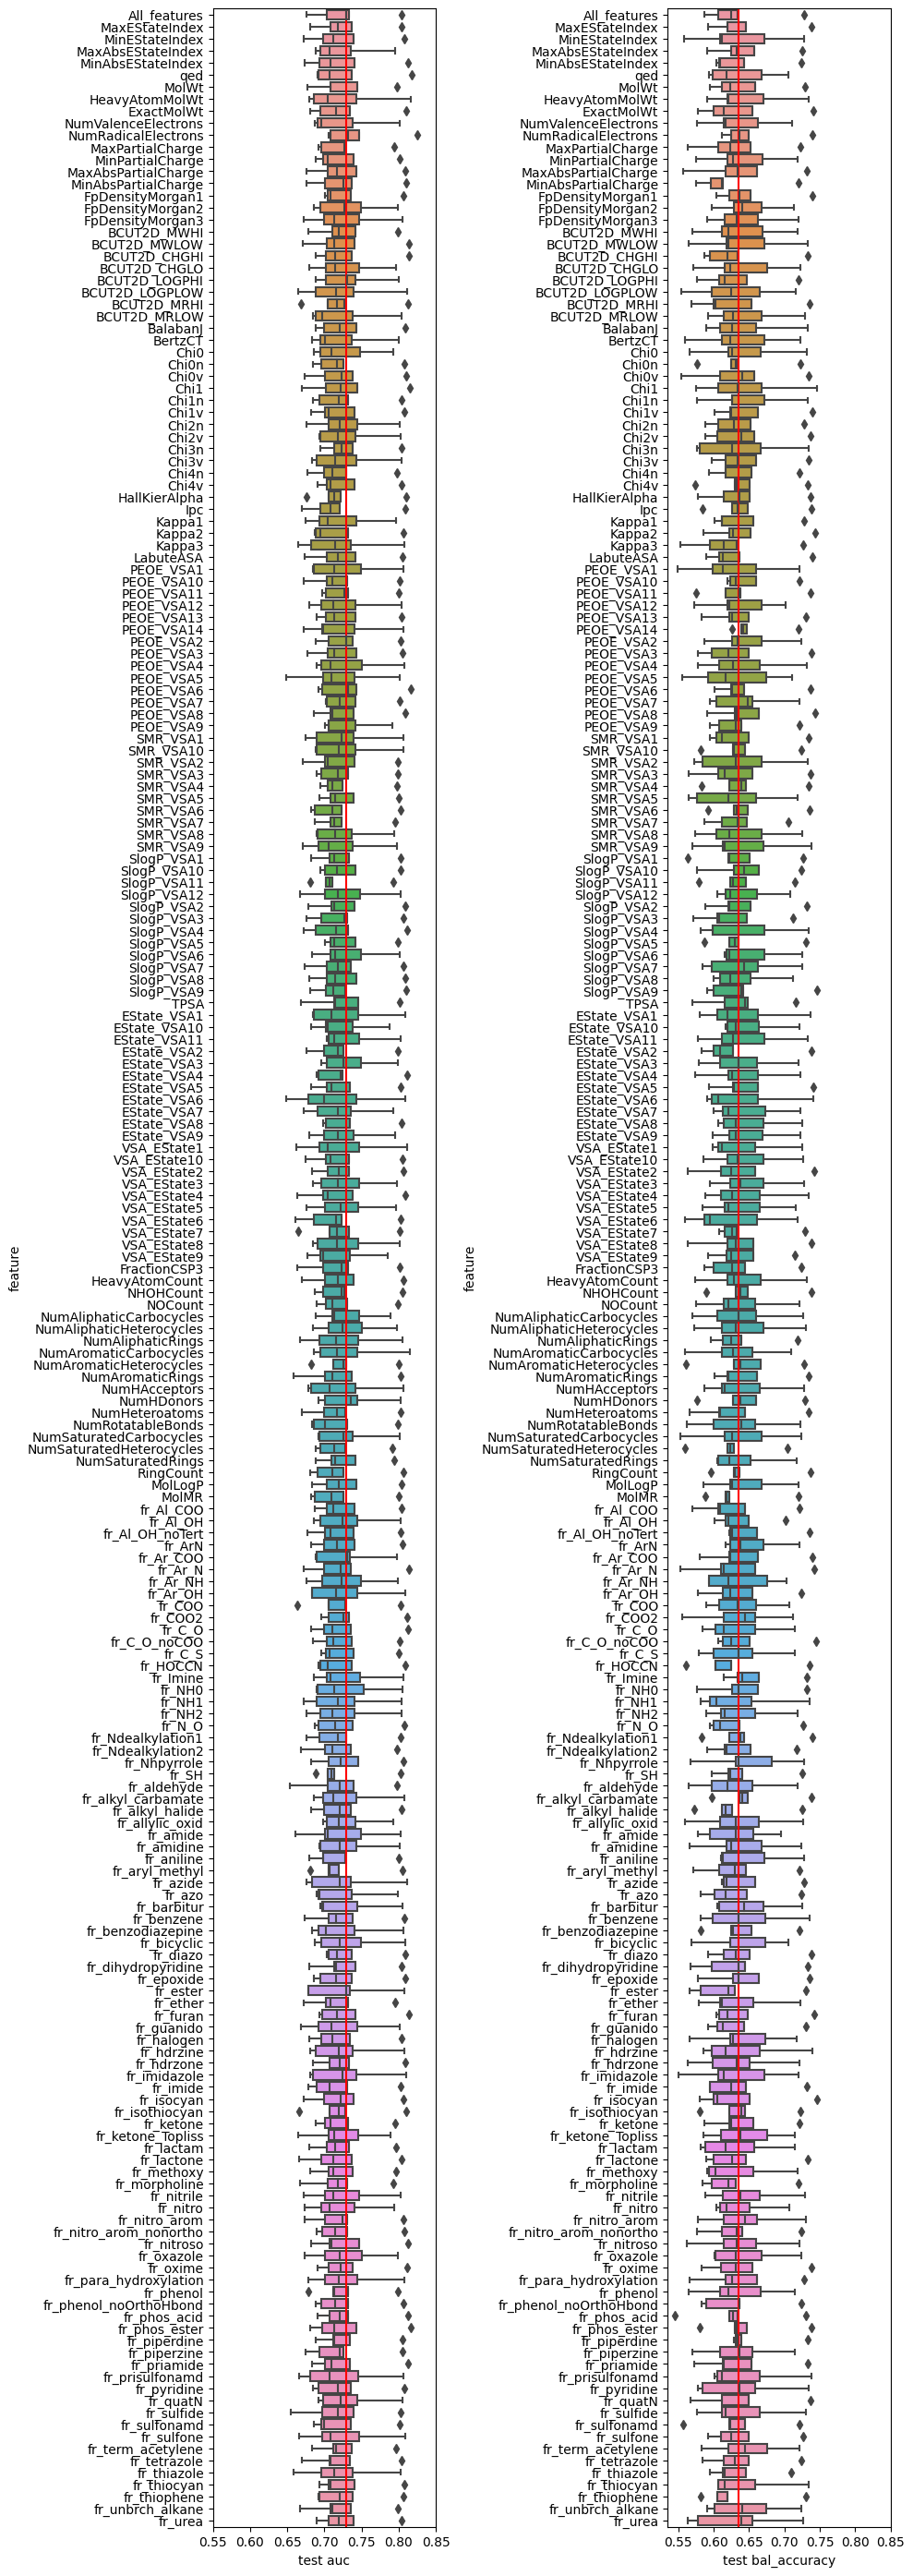

In [ ]:
#5-fold CV
#Get means of cv scores
mcrd_ablation_cv_df['auc_mean']=mcrd_ablation_cv_df['test auc'].apply(np.mean)
mcrd_ablation_cv_df['ba_mean']=mcrd_ablation_cv_df['test bal_accuracy'].apply(np.mean)

#Explode list of scores to separate rows for plotting boxplots 
mcrd_ab_cv_auc = mcrd_ablation_cv_df.explode('test auc')
mcrd_ab_cv_ba = mcrd_ablation_cv_df.explode('test bal_accuracy')

#Plot all ablation data
fig, ax = plt.subplots(ncols=2, figsize=(10,28))
sns.boxplot(data=mcrd_ab_cv_auc, x="test auc", y="feature", ax=ax[0]) 
sns.boxplot(data=mcrd_ab_cv_ba, x="test bal_accuracy", y="feature", ax=ax[1]) 
ax[0].set_xticks(np.arange(0.55, 0.87, 0.05))
ax[1].set_xticks(np.arange(0.55, 0.87, 0.05))
ax[0].axvline(x=mcrd_ablation_cv_df['auc_mean'][0], color='r')
ax[1].axvline(x=mcrd_ablation_cv_df['ba_mean'][0], color='r')

plt.tight_layout()

### Plot top 20 feature ablation hits: figure generation for report

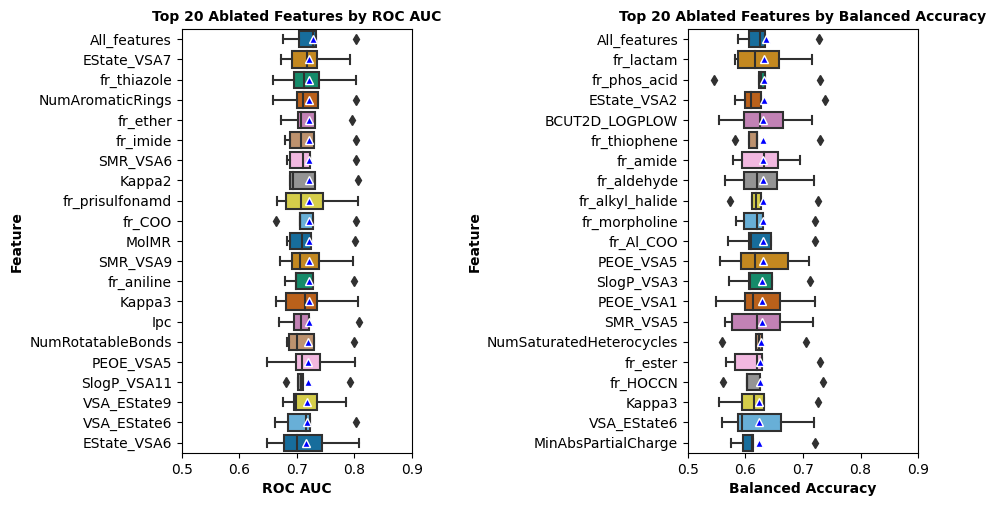

In [ ]:
#5-fold CV
#Get top 20 hits in each metric
mcrd_ablation_hits_cv_auc=pd.concat([mcrd_ablation_cv_df.head(1), mcrd_ablation_cv_df.sort_values(by='auc_mean',ascending=False).tail(20)])
mcrd_ablation_hits_cv_ba=pd.concat([mcrd_ablation_cv_df.head(1), mcrd_ablation_cv_df.sort_values(by='ba_mean',ascending=False).tail(20)])
mcrd_ab_cv_auc_top20 = mcrd_ablation_hits_cv_auc.explode('test auc')
mcrd_ab_cv_ba_top20 = mcrd_ablation_hits_cv_ba.explode('test bal_accuracy')

#Plot top 20 ablation hits for either auc or balanced accuracy
fig, ax = plt.subplots(ncols=2, figsize=(9.5,5.5))
fig.subplots_adjust(wspace=1.2)
sns.boxplot(data=mcrd_ab_cv_auc_top20, x="test auc", y="feature", palette="colorblind", 
            showmeans=True, meanprops={"markerfacecolor":"blue", "markeredgecolor":"white"}, ax=ax[0]) 
sns.boxplot(data=mcrd_ab_cv_ba_top20, x="test bal_accuracy", y="feature", palette="colorblind", 
            showmeans=True, meanprops={"markerfacecolor":"blue", "markeredgecolor":"white"}, ax=ax[1]) 

ax[0].set_title('Top 20 Ablated Features by ROC AUC', fontsize=10, weight='bold')
ax[1].set_title('Top 20 Ablated Features by Balanced Accuracy', fontsize=10, weight='bold')
ax[0].set_xticks(np.arange(0.50, 1, 0.1))
ax[1].set_xticks(np.arange(0.50, 1, 0.1))
ax[0].set_xlabel('ROC AUC', weight='bold')
ax[0].set_ylabel('Feature', weight='bold')
ax[1].set_xlabel('Balanced Accuracy', weight='bold')
ax[1].set_ylabel('Feature', weight='bold')

plt.show()

##Learning curves with CV for Multitask Classifier with RDKit descriptors

### Define function to obtain data for learning curves with CV

In [ ]:
def learning_curve_mcrd_cv(training_sizes, transformers, train_dataset, test_dataset, k=3):
    train_auc_scores_list = list()
    train_ba_scores_list = list()
    test_auc_scores_list = list()
    test_ba_scores_list = list()

    traintest_dataset = dc.data.NumpyDataset.merge([train_dataset, test_dataset])

    tox21_tasks = ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD','NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']
    metrics = [dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean, mode="classification"), dc.metrics.Metric(dc.metrics.balanced_accuracy_score, np.mean, mode="classification")]
    estimator_params_mcrd = {'n_tasks':12, 'n_features':208, 'layer_sizes':[1000, 1000],
                    'dropouts':0.2,'learning_rate': 0.0005,'random_state':2}
    fit_params_mcrd={'nb_epoch':10}
    
    for size in training_sizes: 
      random.seed(30)
      sample_list = random.sample(range(0, 7048), size)
      traintest_sample_X = [traintest_dataset.X[i] for i in sample_list]
      traintest_sample_y = [traintest_dataset.y[i] for i in sample_list]
      traintest_sample_w = [traintest_dataset.w[i] for i in sample_list]
      traintest_sample_ids = [traintest_dataset.ids[i] for i in sample_list]

      traintest_sampled_dataset = dc.data.DiskDataset.from_numpy(traintest_sample_X, traintest_sample_y, traintest_sample_w, 
                                                      tasks=tox21_tasks, ids=traintest_sample_ids)
      cv_scores_all = dc_cross_validate(dc.models.MultitaskClassifier, traintest_sampled_dataset, estimator_params_mcrd, 
                            k=k, fit_params=fit_params_mcrd, return_train_score=True)       

      train_auc_scores_list.append(cv_scores_all[0]['train_score'])
      train_ba_scores_list.append(cv_scores_all[1]['train_score'])
      test_auc_scores_list.append(cv_scores_all[0]['test_score'])
      test_ba_scores_list.append(cv_scores_all[1]['test_score'])

    score_list_df = pd.DataFrame(data={
        'training sample size': training_sizes, 
        'train auc': train_auc_scores_list,
        'train balanced accuracy': train_ba_scores_list,
        'test auc': test_auc_scores_list,
        'test balanced accuracy': test_ba_scores_list
    }) 
    
    return score_list_df

In [ ]:
# Took ~1min
# Note: training sizes of <400 are likely to give 'ValueError: Only one class present in y_true. ROC AUC score is not defined in that case'.
lc_mcrd_cv_df = learning_curve_mcrd_cv([400, 500, 750, 1000, 2000, 3000, 4000, 5000, 6000, 7031], 
    transformers2, train_dataset2_f, test_dataset2_f, k=3)

#Get means of cv scores
lc_mcrd_cv_df['train_auc_mean']=lc_mcrd_cv_df['train auc'].apply(np.mean)
lc_mcrd_cv_df['train_ba_mean']=lc_mcrd_cv_df['train balanced accuracy'].apply(np.mean)
lc_mcrd_cv_df['test_auc_mean']=lc_mcrd_cv_df['test auc'].apply(np.mean)
lc_mcrd_cv_df['test_ba_mean']=lc_mcrd_cv_df['test balanced accuracy'].apply(np.mean)

lc_mcrd_cv_df['train_auc_std']=lc_mcrd_cv_df['train auc'].apply(np.std)
lc_mcrd_cv_df['train_ba_std']=lc_mcrd_cv_df['train balanced accuracy'].apply(np.std)
lc_mcrd_cv_df['test_auc_std']=lc_mcrd_cv_df['test auc'].apply(np.std)
lc_mcrd_cv_df['test_ba_std']=lc_mcrd_cv_df['test balanced accuracy'].apply(np.std)

lc_mcrd_cv_df

,training sample size,train auc,train balanced accuracy,test auc,test balanced accuracy,train_auc_mean,train_ba_mean,test_auc_mean,test_ba_mean,train_auc_std,train_ba_std,test_auc_std,test_ba_std
0,400,"[0.8444813281294646, 0.8486482767188396, 0.879...","[0.7171714570670394, 0.6629741035661709, 0.750...","[0.5525696396403725, 0.6433289107787173, 0.660...","[0.5578671516318817, 0.5855728685909536, 0.582...",0.857614,0.710058,0.618741,0.575212,0.015718,0.035894,0.047302,0.012342
1,500,"[0.8368789721314371, 0.8628013685485995, 0.879...","[0.713559887362147, 0.6982226584587737, 0.7644...","[0.6642824872027884, 0.6348744471416979, 0.684...","[0.5843510972660577, 0.5741835573986879, 0.612...",0.859664,0.725415,0.661246,0.590213,0.017465,0.028312,0.020406,0.016026
2,750,"[0.8121086949742825, 0.8531117466485051, 0.861...","[0.7123743808535049, 0.7508210335366408, 0.756...","[0.6669108056875089, 0.6241720694376021, 0.678...","[0.6247324861383405, 0.5761764163379982, 0.614...",0.842376,0.740013,0.656502,0.605015,0.021701,0.019697,0.023339,0.020846
3,1000,"[0.8065032061626342, 0.8691828104449697, 0.873...","[0.7112750989657352, 0.7604468087668298, 0.764...","[0.7640040781115546, 0.6476610386229328, 0.723...","[0.7106745987530032, 0.5876169618139945, 0.642...",0.849739,0.745552,0.711856,0.646924,0.030624,0.024306,0.048255,0.050336
4,2000,"[0.8182001876143126, 0.8346130566624939, 0.873...","[0.7266450446127117, 0.7285614013737639, 0.787...","[0.743743418153469, 0.7039949747132696, 0.7179...","[0.7191840182666508, 0.6286682639574095, 0.642...",0.842146,0.747475,0.721880,0.663398,0.023246,0.028113,0.016469,0.039840
5,3000,"[0.7912152383344307, 0.8172266438712081, 0.857...","[0.7030060048007846, 0.7267759620526489, 0.765...","[0.7406926832479934, 0.6693507612994729, 0.700...","[0.6737535362950774, 0.633179396543162, 0.6304...",0.822144,0.731668,0.703535,0.645801,0.027482,0.025634,0.029201,0.019796
6,4000,"[0.7846902068434072, 0.8243404647596342, 0.849...","[0.6790520833308928, 0.7297147421871483, 0.764...","[0.7454877995976275, 0.6883023765373504, 0.705...","[0.6824888633251457, 0.6263714152169808, 0.631...",0.819624,0.724430,0.713134,0.646741,0.026806,0.035093,0.023944,0.025360
7,5000,"[0.8102454227888133, 0.8311799319314858, 0.864...","[0.7070806829550159, 0.7309579988995006, 0.785...","[0.7745328824164092, 0.7492298373911274, 0.707...","[0.7032443526458909, 0.6707198409765615, 0.618...",0.835149,0.741288,0.743765,0.664176,0.022133,0.032966,0.027625,0.034879
8,6000,"[0.7962201652328198, 0.8407513971881393, 0.872...","[0.7121971527307048, 0.7560134567366187, 0.778...","[0.7891097955994267, 0.7324832291969137, 0.691...","[0.7154781736824943, 0.6690948273037552, 0.613...",0.836462,0.748957,0.737816,0.665898,0.031254,0.027589,0.039882,0.041848
9,7031,"[0.8081797199575048, 0.8298460373631319, 0.873...","[0.6865378249335548, 0.7491745443888306, 0.790...","[0.8018151146992244, 0.7301391130955737, 0.698...","[0.7351397965119914, 0.6677172701094946, 0.631...",0.837247,0.742103,0.743363,0.678102,0.027262,0.042775,0.043347,0.042963


#### Check colorblind palette color codes

In [ ]:
pal = sns.color_palette('colorblind', 7)
print(pal.as_hex())
pal.as_hex()

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4']


['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4']

### Plot learning curves for Multitask Classifier

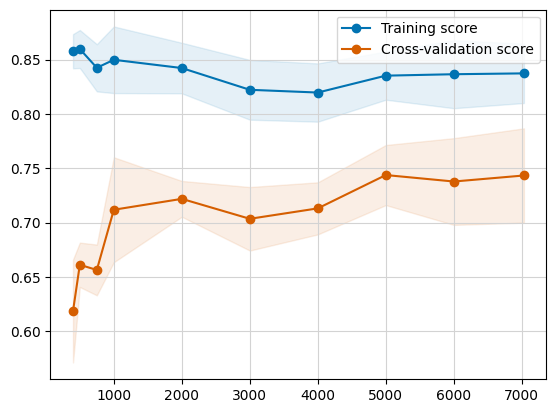

In [ ]:
train_sizes=[400, 500, 750, 1000, 2000, 3000, 4000, 5000, 6000, 7031]    
train_scores_mean = lc_mcrd_cv_df['train_auc_mean']
train_scores_std = lc_mcrd_cv_df['train_auc_std']
test_scores_mean = lc_mcrd_cv_df['test_auc_mean']
test_scores_std = lc_mcrd_cv_df['test_auc_std']

# Plot learning curve
plt.grid(color='lightgrey')
plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="#0173b2")
plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="#d55e00")
plt.plot(train_sizes, train_scores_mean, "o-", color="#0173b2", label="Training score") #use colorblind colors
plt.plot(train_sizes, test_scores_mean, "o-", color="#d55e00", label="Cross-validation score") #use colorblind colors
plt.legend(loc="best")
plt.show()

## AttentiveFP Model

### Must install dgl and dgllife for model to work

In [ ]:
!pip install  dgl -f https://data.dgl.ai/wheels/cu117/repo.html
!pip install  dgllife

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/cu117/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 MB 4.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 456.4 kB/s eta 0:00:00


### Load, featurize and split Tox21 datasets via DeepChem

In [ ]:
tox21_tasks4b, tox21_datasets4b, transformers4b = dc.molnet.load_tox21(featurizer=dc.feat.MolGraphConvFeaturizer(use_edges=True))
train_dataset4b, valid_dataset4b, test_dataset4b = tox21_datasets4b
train_dataset4b

[17:37:29] WARNING: not removing hydrogen atom without neighbors
/usr/local/lib/python3.9/dist-packages/deepchem/feat/base_classes.py:322: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(features)
[17:38:27] WARNING: not removing hydrogen atom without neighbors


<DiskDataset X.shape: (6249,), y.shape: (6249, 12), w.shape: (6249, 12), task_names: ['NR-AR' 'NR-AR-LBD' 'NR-AhR' ... 'SR-HSE' 'SR-MMP' 'SR-p53']>

### Reload saved model (previously trained on 3/23)

In [ ]:
afp_reload=dc.models.AttentiveFPModel(n_tasks=12, batch_size=100, mode='classification', learning_rate=0.0005, dropout=0.4,random_state=2, model_dir='./someDirectory/someFolder')
afp_reload.restore()
print("Timestamp:", date_now, datetime.now(pytz.timezone('America/Vancouver')).strftime("%H:%M:%S"))
metrics = [dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean, mode="classification"),dc.metrics.Metric(dc.metrics.balanced_accuracy_score, np.mean, mode="classification")]

afp_train_scores = afp_reload.evaluate(train_dataset4b, metrics, transformers4b)
afp_test_scores = afp_reload.evaluate(test_dataset4b, metrics, transformers4b)
print('Train scores: ', afp_train_scores)
print('Test scores: ', afp_test_scores)

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
Timestamp: 2023-04-13 10:38:32


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (
/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Train scores:  {'mean-roc_auc_score': 0.9597742738378705, 'mean-balanced_accuracy_score': 0.9132702614288238}
Test scores:  {'mean-roc_auc_score': 0.7349533419945021, 'mean-balanced_accuracy_score': 0.6790515926855938}


### AFP final model CV results

In [ ]:
#5-fold CV, took 21 min 
estimator_params_afp = {'n_tasks':12, 'batch_size': 100, 'dropouts':0.4,'learning_rate': 0.0005,'random_state':2}
fit_params_afp ={'nb_epoch':50}
afp_merged_traintest = dc.data.NumpyDataset.merge([train_dataset4b, test_dataset4b])

afp_cv_scores = dc_cross_validate(dc.models.AttentiveFPModel, afp_merged_traintest, estimator_params_afp, 
                            k=5, fit_params=fit_params_afp, return_train_score=True)
afp_cv_df = pd.DataFrame(data = {'roc_auc_train': afp_cv_scores[0]['train_score'], 
                                 'roc_auc_test': afp_cv_scores[0]['test_score'],
                                 'ba_train': afp_cv_scores[1]['train_score'], 
                                 'ba_test': afp_cv_scores[1]['test_score']})
afp_cv_df.describe()

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (
/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (
/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the

,roc_auc_train,roc_auc_test,ba_train,ba_test
count,5.000000,5.000000,5.000000,5.000000
mean,0.968739,0.727792,0.921954,0.673935
std,0.008832,0.057908,0.018031,0.048002
min,0.958738,0.660254,0.898196,0.612833
25%,0.960021,0.684176,0.907788,0.642872
50%,0.971430,0.741267,0.928798,0.687555
75%,0.976339,0.745028,0.935829,0.688228
max,0.977165,0.808235,0.939161,0.738188


### Plot Confusion Matrix for AFP: figure generation for report

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


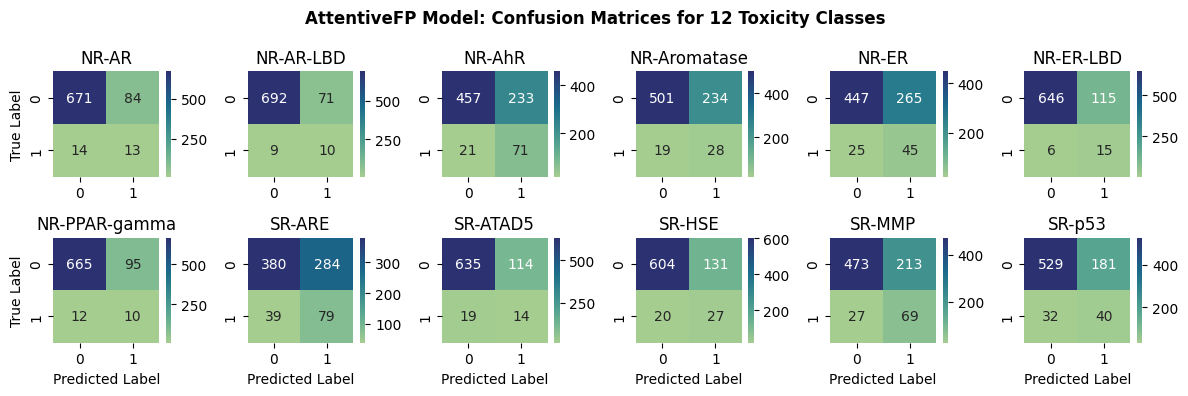

In [ ]:
cm_afp = get_confusionmatrix(afp_reload, test_dataset4b)

fig, axes = plt.subplots(2, 6, figsize=(12,4))
fig.suptitle('AttentiveFP Model: Confusion Matrices for 12 Toxicity Classes', weight='bold')
first_six = ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD']
last_six = ['NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']

for i in range(6):
  axes[0][i].set_title(first_six[i])
  sns.heatmap(ax=axes[0][i], data=pd.DataFrame(cm_afp[i]), annot=True,cmap='crest', fmt='g')
axes[0][0].set_ylabel('True Label')
for j in range(6):
  axes[1][j].set_title(last_six[j])
  sns.heatmap(ax=axes[1][j], data=pd.DataFrame(cm_afp[j+6]), annot=True,cmap='crest', fmt='g')
  axes[1][j].set_xlabel('Predicted Label')
axes[1][0].set_ylabel('True Label')

plt.tight_layout()

In [ ]:
# Note: sometimes training sizes of <400 would result in 'ValueError: Only one class present in y_true. ROC AUC score is not defined in that case'.
# Solution to work around problem: Try adjusting setting random.seed() to a different number
def learning_curve_afp_cv(training_sizes, transformers, train_dataset, test_dataset, k=3):
    train_auc_scores_list = list()
    train_ba_scores_list = list()
    test_auc_scores_list = list()
    test_ba_scores_list = list()

    traintest_dataset = dc.data.NumpyDataset.merge([train_dataset, test_dataset])

    tox21_tasks = ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD','NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']
    metrics = [dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean, mode="classification"), dc.metrics.Metric(dc.metrics.balanced_accuracy_score, np.mean, mode="classification")]
    estimator_params_afp = {'n_tasks':12, 'mode':'classification', 'batch_size':100,
                    'dropout':0.4,'learning_rate': 0.0005,'random_state':2}
    fit_params_afp={'nb_epoch':10}
    
    for size in training_sizes: 
      random.seed(0) 
      sample_list = random.sample(range(0, 7031), size)
      traintest_sample_X = [traintest_dataset.X[i] for i in sample_list]
      traintest_sample_y = [traintest_dataset.y[i] for i in sample_list]
      traintest_sample_w = [traintest_dataset.w[i] for i in sample_list]
      traintest_sample_ids = [traintest_dataset.ids[i] for i in sample_list]

      traintest_sampled_dataset = dc.data.DiskDataset.from_numpy(traintest_sample_X, traintest_sample_y, traintest_sample_w, 
                                                      tasks=tox21_tasks, ids=traintest_sample_ids)
      cv_scores_all = dc_cross_validate(dc.models.AttentiveFPModel, traintest_sampled_dataset, estimator_params_afp, 
                            k=k, fit_params=fit_params_afp, return_train_score=True)     
      
      train_auc_scores_list.append(cv_scores_all[0]['train_score'])
      train_ba_scores_list.append(cv_scores_all[1]['train_score'])
      test_auc_scores_list.append(cv_scores_all[0]['test_score'])
      test_ba_scores_list.append(cv_scores_all[1]['test_score'])

    score_list_df = pd.DataFrame(data={
        'training sample size': training_sizes, 
        'train auc': train_auc_scores_list,
        'train balanced accuracy': train_ba_scores_list,
        'test auc': test_auc_scores_list,
        'test balanced accuracy': test_ba_scores_list
    }) 
    return score_list_df

In [ ]:
#took 11 min
lc_afp_cv_df = learning_curve_afp_cv([400, 500, 750, 1000, 2000, 3000, 4000, 5000, 6000, 7031], transformers4b, train_dataset4b, test_dataset4b, k=3)

#Get means and stdev of cv scores
lc_afp_cv_df['train_auc_mean']=lc_afp_cv_df['train auc'].apply(np.mean)
lc_afp_cv_df['train_ba_mean']=lc_afp_cv_df['train balanced accuracy'].apply(np.mean)
lc_afp_cv_df['test_auc_mean']=lc_afp_cv_df['test auc'].apply(np.mean)
lc_afp_cv_df['test_ba_mean']=lc_afp_cv_df['test balanced accuracy'].apply(np.mean)
lc_afp_cv_df['train_auc_std']=lc_afp_cv_df['train auc'].apply(np.std)
lc_afp_cv_df['train_ba_std']=lc_afp_cv_df['train balanced accuracy'].apply(np.std)
lc_afp_cv_df['test_auc_std']=lc_afp_cv_df['test auc'].apply(np.std)
lc_afp_cv_df['test_ba_std']=lc_afp_cv_df['test balanced accuracy'].apply(np.std)
lc_afp_cv_df

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (
/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (
/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the

,training sample size,train auc,train balanced accuracy,test auc,test balanced accuracy,train_auc_mean,train_ba_mean,test_auc_mean,test_ba_mean,train_auc_std,train_ba_std,test_auc_std,test_ba_std
0,400,"[0.6773703197678179, 0.7104166794300313, 0.748...","[0.5715127894821124, 0.6376015635365615, 0.679...","[0.6494874855424501, 0.5927461024195374, 0.601...","[0.543961844341851, 0.5491187754152175, 0.5904...",0.712037,0.629475,0.614741,0.561164,0.028989,0.044382,0.024858,0.020787
1,500,"[0.6942072576744932, 0.7251916010894468, 0.733...","[0.5948379432964909, 0.6704733019724539, 0.663...","[0.6262039165710331, 0.5546913356913169, 0.594...","[0.5661407112357771, 0.5079798573144397, 0.604...",0.717524,0.642894,0.591770,0.559693,0.016806,0.034104,0.029255,0.039853
2,750,"[0.7072507771995875, 0.741771610435736, 0.7550...","[0.6342927344600354, 0.6745955590510467, 0.688...","[0.6949594817582095, 0.634163885854923, 0.6106...","[0.6155588910029594, 0.5706482933582246, 0.582...",0.734678,0.665854,0.646607,0.589534,0.020133,0.023046,0.035507,0.019017
3,1000,"[0.7248862792770527, 0.753604270965698, 0.7836...","[0.6441479245079965, 0.679859679270237, 0.7116...","[0.7148967453131574, 0.650616495022959, 0.6312...","[0.6148039887315911, 0.5957722702924949, 0.590...",0.754054,0.678540,0.665594,0.600227,0.024001,0.027558,0.035746,0.010564
4,2000,"[0.7544743753670903, 0.7773797487023213, 0.809...","[0.6721879610012284, 0.7022226069082512, 0.733...","[0.7587570785919725, 0.7039276035236398, 0.684...","[0.6707697297782994, 0.6274308088629519, 0.627...",0.780340,0.702475,0.715701,0.642013,0.022426,0.024834,0.031470,0.020335
5,3000,"[0.7825097823628213, 0.7979641993650667, 0.821...","[0.7022131250773258, 0.7259426937615207, 0.749...","[0.7590539221156112, 0.7365514811504635, 0.685...","[0.6926530167791394, 0.66531505892194, 0.62601...",0.800539,0.726009,0.727049,0.661327,0.015877,0.019457,0.030754,0.027352
6,4000,"[0.7945512601538688, 0.8020842935741134, 0.833...","[0.7188116663894754, 0.7272401179700014, 0.735...","[0.7889342739342431, 0.7506974319728622, 0.700...","[0.7157482037935056, 0.6811467037862049, 0.633...",0.810096,0.727107,0.746778,0.676706,0.016938,0.006720,0.036128,0.033837
7,5000,"[0.8017830434079528, 0.8095771717545901, 0.834...","[0.7214351702000826, 0.7280407704750947, 0.756...","[0.7933724502357835, 0.7375882175407482, 0.710...","[0.7146349678415688, 0.6622725279376096, 0.623...",0.815309,0.735440,0.747295,0.666681,0.013984,0.015374,0.034352,0.037484
8,6000,"[0.8046109195531471, 0.8178574789316849, 0.837...","[0.7270360004710179, 0.7426909043403161, 0.755...","[0.7882710710789205, 0.7559698759512884, 0.718...","[0.7145045653090376, 0.686968726717799, 0.6146...",0.820070,0.741624,0.754210,0.672053,0.013616,0.011500,0.028556,0.042093
9,7031,"[0.8027968649761609, 0.8176280721273511, 0.849...","[0.7283102698743794, 0.7410335426895663, 0.768...","[0.8068494789774232, 0.7436621300058498, 0.736...","[0.7201487155756343, 0.6666088274419513, 0.661...",0.823447,0.745818,0.762201,0.682855,0.019671,0.016597,0.031722,0.026443


### Plot learning curves for both models: figures generated for report 
Reference: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html

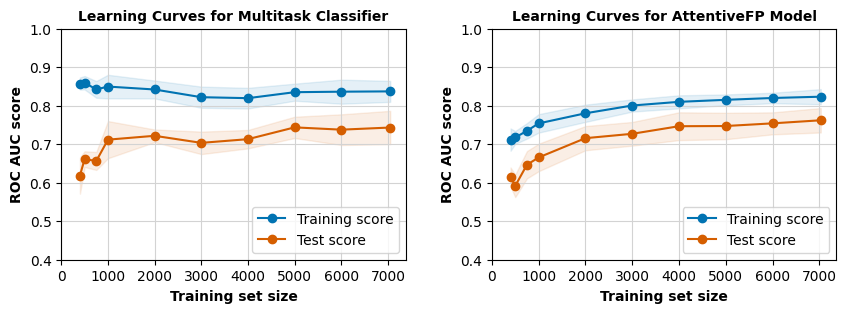

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,3))
fig.subplots_adjust(wspace=0.25)
train_sizes_mcrd=[400, 500, 750, 1000, 2000, 3000, 4000, 5000, 6000, 7048] 
train_sizes_afp=[400, 500, 750, 1000, 2000, 3000, 4000, 5000, 6000, 7031]    
train_scores_mean_mcrd = lc_mcrd_cv_df['train_auc_mean']
train_scores_std_mcrd = lc_mcrd_cv_df['train_auc_std']
test_scores_mean_mcrd = lc_mcrd_cv_df['test_auc_mean']
test_scores_std_mcrd = lc_mcrd_cv_df['test_auc_std']
train_scores_mean_afp= lc_afp_cv_df['train_auc_mean']
train_scores_std_afp = lc_afp_cv_df['train_auc_std']
test_scores_mean_afp = lc_afp_cv_df['test_auc_mean']
test_scores_std_afp = lc_afp_cv_df['test_auc_std']

axes[0].grid(color='lightgrey')
axes[0].fill_between(
    train_sizes_mcrd,
    train_scores_mean_mcrd - train_scores_std_mcrd,
    train_scores_mean_mcrd + train_scores_std_mcrd,
    alpha=0.1,
    color="#0173b2")
axes[0].fill_between(
    train_sizes_mcrd,
    test_scores_mean_mcrd - test_scores_std_mcrd,
    test_scores_mean_mcrd + test_scores_std_mcrd,
    alpha=0.1,
    color="#d55e00")
axes[0].plot(train_sizes_mcrd, train_scores_mean_mcrd, "o-", color="#0173b2", label="Training score")
axes[0].plot(train_sizes_mcrd, test_scores_mean_mcrd, "o-", color="#d55e00", label="Test score")
axes[0].legend(loc="lower right")
axes[0].set_title("Learning Curves for Multitask Classifier", size=10, weight='bold')
axes[0].set_yticks(np.arange(0.4, 1.1, 0.1))
axes[0].set_xticks(np.arange(0, 8000, 1000))
axes[0].set_xlabel('Training set size', weight='bold')
axes[0].set_ylabel('ROC AUC score', weight='bold')

axes[1].grid(color='lightgrey')
axes[1].fill_between(
    train_sizes_afp,
    train_scores_mean_afp - train_scores_std_afp,
    train_scores_mean_afp + train_scores_std_afp,
    alpha=0.1,
    color="#0173b2")
axes[1].fill_between(
    train_sizes_afp,
    test_scores_mean_afp - test_scores_std_afp,
    test_scores_mean_afp + test_scores_std_afp,
    alpha=0.1,
    color="#d55e00")
axes[1].plot(train_sizes_afp, train_scores_mean_afp, "o-", color="#0173b2", label="Training score")
axes[1].plot(train_sizes_afp, test_scores_mean_afp, "o-", color="#d55e00", label="Test score")
axes[1].legend(loc="lower right")
axes[1].set_title("Learning Curves for AttentiveFP Model", size=10, weight='bold')
axes[1].set_yticks(np.arange(0.4, 1.1, 0.1))
axes[1].set_xticks(np.arange(0, 8000, 1000))
axes[1].set_xlabel('Training set size', weight='bold')
axes[1].set_ylabel('ROC AUC score', weight='bold')

plt.show()

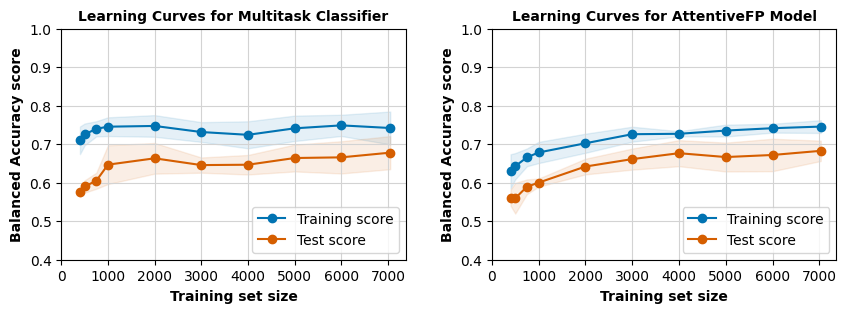

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,3))
fig.subplots_adjust(wspace=0.25)
train_sizes_mcrd=[400, 500, 750, 1000, 2000, 3000, 4000, 5000, 6000, 7048] 
train_sizes_afp=[400, 500, 750, 1000, 2000, 3000, 4000, 5000, 6000, 7031]    
train_scores_mean_mcrd = lc_mcrd_cv_df['train_ba_mean']
train_scores_std_mcrd = lc_mcrd_cv_df['train_ba_std']
test_scores_mean_mcrd = lc_mcrd_cv_df['test_ba_mean']
test_scores_std_mcrd = lc_mcrd_cv_df['test_ba_std']
train_scores_mean_afp= lc_afp_cv_df['train_ba_mean']
train_scores_std_afp = lc_afp_cv_df['train_ba_std']
test_scores_mean_afp = lc_afp_cv_df['test_ba_mean']
test_scores_std_afp = lc_afp_cv_df['test_ba_std']

axes[0].grid(color='lightgrey')
axes[0].fill_between(
    train_sizes_mcrd,
    train_scores_mean_mcrd - train_scores_std_mcrd,
    train_scores_mean_mcrd + train_scores_std_mcrd,
    alpha=0.1,
    color="#0173b2")
axes[0].fill_between(
    train_sizes_mcrd,
    test_scores_mean_mcrd - test_scores_std_mcrd,
    test_scores_mean_mcrd + test_scores_std_mcrd,
    alpha=0.1,
    color="#d55e00")
axes[0].plot(train_sizes_mcrd, train_scores_mean_mcrd, "o-", color="#0173b2", label="Training score")
axes[0].plot(train_sizes_mcrd, test_scores_mean_mcrd, "o-", color="#d55e00", label="Test score")
axes[0].legend(loc="lower right")
axes[0].set_title("Learning Curves for Multitask Classifier", size=10, weight='bold')
axes[0].set_yticks(np.arange(0.4, 1.1, 0.1))
axes[0].set_xticks(np.arange(0, 8000, 1000))
axes[0].set_xlabel('Training set size', weight='bold')
axes[0].set_ylabel('Balanced Accuracy score', weight='bold')

axes[1].grid(color='lightgrey')
axes[1].fill_between(
    train_sizes_afp,
    train_scores_mean_afp - train_scores_std_afp,
    train_scores_mean_afp + train_scores_std_afp,
    alpha=0.1,
    color="#0173b2")
axes[1].fill_between(
    train_sizes_afp,
    test_scores_mean_afp - test_scores_std_afp,
    test_scores_mean_afp + test_scores_std_afp,
    alpha=0.1,
    color="#d55e00")
axes[1].plot(train_sizes_afp, train_scores_mean_afp, "o-", color="#0173b2", label="Training score")
axes[1].plot(train_sizes_afp, test_scores_mean_afp, "o-", color="#d55e00", label="Test score")
axes[1].legend(loc="lower right")
axes[1].set_title("Learning Curves for AttentiveFP Model", size=10, weight='bold')
axes[1].set_yticks(np.arange(0.4, 1.1, 0.1))
axes[1].set_xticks(np.arange(0, 8000, 1000))
axes[1].set_xlabel('Training set size', weight='bold')
axes[1].set_ylabel('Balanced Accuracy score', weight='bold')

plt.show()

# End of Notebook